## ECOSTRESS Data in Python

[ECOSTRESS](https://www.nasa.gov/mission_pages/ecostress/overview), which stands for ECOsystem Spaceborne Thermal Radiometer Experiment on Space Station, is a radiometer that has been attached to the International Space Station since 2018, and collects temperature data on plants. This data can be used to monitor plant life and sense how much water they are releasing to manage their temperature. From this data, we can derive evapotransporation (ET), the Evaporative Stress Index, and calculate the Water Use Efficiency (WUE) of different areas. 

The raw data from this sensor can be difficult to deal with. It comes in h5 format like GEDI data does, but has a very different way of extracting the relevant information. [NASA built a tool](https://git.earthdata.nasa.gov/projects/LPDUR/repos/ecostress_swath2grid/browse) for users to use so that they can import any of the bands they want, alongside the geospatial band of the sensor, and create a much more familiar geotiff. The tool is in Python and can be run from a terminal. The format for changing the file format of the downloaded data is shown below.

```
> python ECOSTRESS_swath2grid.py --proj <insert reprojection desired, Options: GEO and UTM> --dir <insert input directory with ECOSTRESS files here>
```

## Types of ECOSTRESS Data

The list of ECOSTRESS products, their names, and the data stored in them can be found [here](https://ecostress.jpl.nasa.gov/data/science-data-products-summary-table), with additional details being shown [here](https://ecostress.jpl.nasa.gov/data/user-guide-documents-table). 

ECOSTRESS, like many remote sensors, has different levels of data that have been cleaned up and made ready for analysis as you get to higher levels. The level 1 data will be raw data, or close to raw data, collected by the satellite that hasn't had many corrections or quality checks ran on it, if any at all. For ECOSTRESS, they provide raw radiance data, geolocation data, and other metadata such as the attitude the images were taken at. Thankfully, while these can be useful, NASA also provides products that combine this data with other data sources to run quality checks and corrections, and then use that to calculate different types of scientific data. Since the ECOSTRESS really is about detecting temperatures, it can be used in awesome ways to monitor active fires when it passes over them. It gets surface temperature information, which is a unique lens to view events like forest fires, as seen here from NASA's website viewing the 2022 Oak fire in California:

<figure>
    <a href="https://ecostress.jpl.nasa.gov/downloads/gallery/00097_oak_fire.jpg">
    <img src="https://ecostress.jpl.nasa.gov/downloads/gallery/00097_oak_fire.jpg"></a>
    <figcaption> A thermal view of the Oak fire on July 22nd, 2022. Source: NASA/JPL-Caltech  
    </figcaption>
</figure>


We will be using the Water Use Efficiency (WUE) product NASA provides. The product we chose uses the Priestley-Taylor Jet Propulsion Laboratory algorithm and data from Landsat, MODIS, and other sources to calculate the WUE of plants imaged. A document explaining the work flow of how this product is created can be found [on NASA's website](https://ecostress.jpl.nasa.gov/downloads/userguides/4b_ECOSTRESS_UserGuide_L4_WUE_20190618.pdf). Reading the documentation, we can see that the units are gross primary production over evapotranspiration (GPP/ET)

For this exercise, we needed both the WUE product (ECO4WUE.001) alongside the geospatial product (ECO1BGEO.001) in order to run them both through the tool NASA made to create a geotiff.

We'll be opening the transformed data, exploring it, then combining it with the GEDI data to do a cross sensor analysis. 

In [1]:
# Import the required libraries

import os
from os import path
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import rasterio as rio
import earthpy as et
import earthpy.plot as ep
from rasterio.plot import plotting_extent
from shapely.geometry import box
import seaborn as sns

In [2]:
# Get working directory
data_path = os.path.join("/home", "jovyan", "data_forest_resiliency", "GEDI_Ecostress")

## Using `rioxarray` to open raster data

`rioxarray` is a package built on top of `xarray`, a powerful tool that can be used to handle raster data in many formats in Python. While there are many packages that can be used to do similar things, such as `rasterio` or `h5py`, one of the advantages of `rioxarray` is it's ability to open up many types of files easily, such as `.tif`, `.h5`, and `.netcdf` file, all of which are common file types in geospatial analysis. Here we use it to open up the `.tif` file, which we can then clip, access the data from, and plot. For more information on using `rioxarray` in Python, see our lesson [here](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/).

In [3]:
# Create path to data
rcew_boundary = gpd.read_file(
    path.join(data_path, 'Hay_sch_polys.geojson'))
ecostress_path = path.join(
    data_path, "ECOSTRESS_L4_WUE_23611_012_20220904T134321_0601_01_WUEavg_GEO.tif")

# Open and clip the data, cliping it to the study area boundary
ecostress = rxr.open_rasterio(ecostress_path).rio.clip(rcew_boundary.geometry)

# GEDI Data
GEDI_path = path.join(data_path, 'GEDI_4A_Hayman.geojson')
GEDI_data = gpd.read_file(GEDI_path)

## Plot the data

Now that we've opened up the data, we can plot it in the Hayman fire bounds and see how it overlaps with our GEDI data from there. We'll use the `plot_bands` function found in `earthpy.plot` to easily plot our raster data. The function takes in rasters and will plot either a single band or multiple bands next to each other depending on how many bands are in your data. It is a good quick way to visualize raster data. 

In order to plot the GeoPandas vector data on top of raster data, we will need to give the raster an extent. We can create this using `plotting_extent` from the `rasterio` library, and assign the extent to our raster to ensure that it will line up with data in the same projection. To learn more on plotting extents, see [the plotting extent lesson](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/plotting-extents/) on [earthdatascience.org](https://www.earthdatascience.org/)

In [4]:
# Create plotting extent to plot data together
ecostress_extent = plotting_extent(ecostress[0], ecostress.rio.transform())

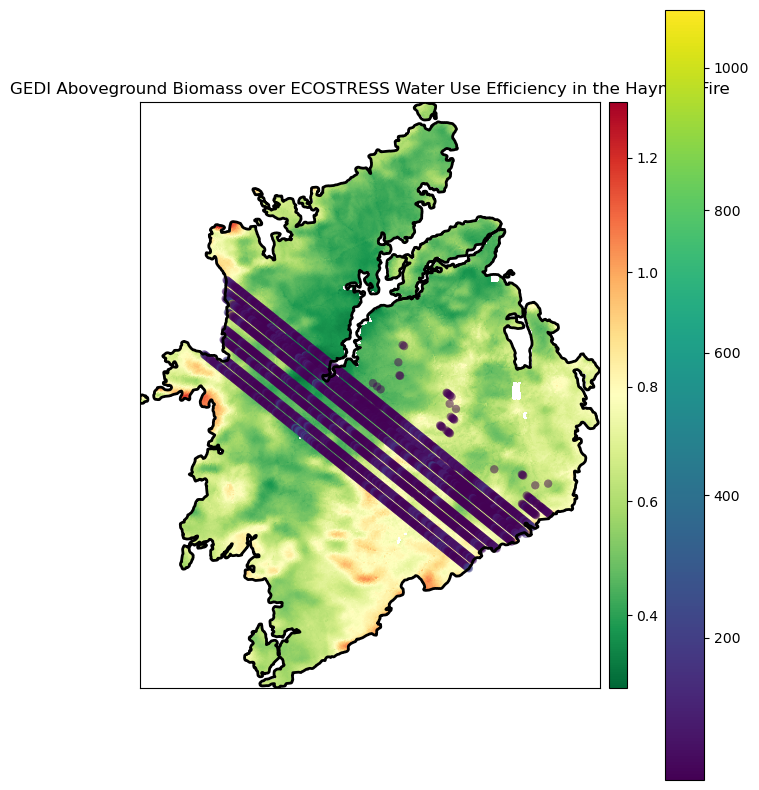

In [5]:
# Plot the GEDI and ECOSTRESS data together!

fig, ax = plt.subplots(figsize=(10, 10))

ep.plot_bands(ecostress,
              ax=ax,
              cmap='RdYlGn_r',
              extent=ecostress_extent,
              title="GEDI Aboveground Biomass over ECOSTRESS Water Use Efficiency in the Hayman Fire")

rcew_boundary.geometry.boundary.plot(ax=ax,
                                     edgecolor='black',
                                     linewidth=2)

GEDI_data.plot(ax=ax,
               column='agbd',
               linewidth=0,
               legend=True,
               alpha=0.5)
plt.show()

## Extract ECOSTRESS raster data to GEDI points

Below are two functions that will extract the point values from a raster. We can use these to get the ECOSTRESS data at the points where we have GEDI data, and combine them into one dataset we can use to see the amount of aboveground biomass (AGBD) and ET together. This is a great way to enhance GEDI data with other datasets, and values like this could be extracted from rasters such as slope, aspect, or elevation. 

GEDI data is collected in circles with a 25 meter diameter over multiple passes, where as the ECOSTRESS data is collected in much wider images. The functions below use the center point of the GEDI footprint to determine which ECOSTRESS value to extract from the raster, using essentially a nearest neighbor approach. We do this instead of interpolating data to avoid using data that was never actually collected. 

In [6]:
def extract_points(raster_path, points):
    """
    Get values of raster at series of points

    Parameters
    ----------
    raster_path: path variable
        Path to the raster to extract data from

    points: GeoDataframe
        List of points to use when extracting data from raster

    Returns
    -------
    values : list
        A list of values at each point from the raster
    """
    # Open raster
    raster = rio.open(raster_path)
    values = []
    # Create a bounding box for the raster and clip the points to that
    points_clip = points.clip(box(*raster.bounds))
    point_num = len(points_clip)
    array = raster.read()
    # Loop through points, get the value of the raster at each xy
    for point in points_clip['geometry']:
        x, y = point.xy[0][0], point.xy[1][0]
        row, col = raster.index(x, y)
        attrs = []
        band_nums = array.shape[0]
        for z in range(band_nums):
            # Looping through all bands
            attrs.append(array[z, row, col])
            values.append([attrs, point])
    # Close raster
    raster.close()
    return (values)


def turn_raster_output_to_gdf(raster_path, points, column_name="col"):
    """
    Get values of raster at series of points and turn the values into a GeoDataFrame

    Parameters
    ----------
    raster_path: path variable
        Path to the raster to extract data from

    points: GeoDataframe
        List of points to use when extracting data from raster

    column_name: string
        Name of the column created in the pandas dataframe with the new data

    Returns
    -------
    GeoDataFrame
        A GeoDataFrame containing all the points and the values from the raster at each point
    """
    # Runs extract_points
    extracted_vals = extract_points(raster_path, points)
    # Turn output into dataframe
    output_pd = pd.DataFrame(extracted_vals)
    lis = output_pd[0].to_list()
    geom = output_pd[1].to_list()
    # Turn output into labeled
    org = pd.DataFrame(lis, columns=[column_name])
    # read points into geodataframe
    return (gpd.GeoDataFrame(org, geometry=geom, crs=points.crs))

In [7]:
# Extracting values from raster
points_with_values = turn_raster_output_to_gdf(
    ecostress_path,
    GEDI_data,
    "WUE")

## Combining Spatial Data 

Combining the newly created data back to the GEDI data can be tricky. You want to make sure the correct values are matched when putting the two columns into a single dataset together. In order to ensure this, we can use the piece of information that both have in common: their spatial data. A spatial join will combine datasets based on spatial overlap, keeping the point data and adding any data from two dataframes into one based on their spatial relation. 

This process can be a little complicated, as it adds many unnecessary columns with old indexes, and may create a lot of extra rows with `na` values. Below, we can run the `sjoin` function, then clean up the resulting dataframe. 

In [8]:
# Running a spatial join on the GEDI data and the data gotten from ECOSTRESS. Dropping unnecessary indices and na values.
WUE_agbd = gpd.sjoin(GEDI_data,
                     points_with_values).reset_index().drop(columns=['index_right', 'index'], axis=1).dropna()

## Display the combined datasets.

Now that we've extracted the values and ran a spatial join, we can see the results using `.head()` in `pandas`. 

In [9]:
# Display dataframe with combined data!
WUE_agbd.head()

,lat_lowestmode,lon_lowestmode,agbd,geometry,WUE
0,39.183799,-105.249182,0.410315,POINT (-105.24918 39.18380),0.537870
1,39.183156,-105.248157,0.624369,POINT (-105.24816 39.18316),0.580189
2,39.156759,-105.217061,1.391625,POINT (-105.21706 39.15676),0.738082
3,39.156436,-105.216546,1.061925,POINT (-105.21655 39.15644),0.744334
4,39.156113,-105.216035,2.221455,POINT (-105.21603 39.15611),0.744334


## Plotting our data against each other

Here, we can plot our WUE data against the AGBD data to see if there's any sort of correlation between the two! It's important to keep in mind when comparing datasets like this any issues that may come from comparing them directly. For example, the fact that the GEDI data is collected over multiple days and aggregated means that comparing it to data collected in a single day, like ECOSTRESS, may not provide the results you are looking for. 

We will drop outliers from the dataset using the `.quantile()` method in `pandas`, then plot the WUE data against the AGBD data using the `seaborn` library, using a function called `.lmplot()`. This will plot the two variables and draw a linear regression as well. 

In [10]:
# Getting values for outliers
upper_outlier_agbd, lower_outlier_agbd = WUE_agbd.agbd.quantile(
    .98), WUE_agbd.agbd.quantile(.2)
upper_outlier_WUE, lower_outlier_WUE = WUE_agbd.WUE.quantile(
    .98), WUE_agbd.WUE.quantile(.2)

# Removing outliers from dataset
WUE_agbd_no_outliers = WUE_agbd[(WUE_agbd.agbd < upper_outlier_agbd) &
                                (WUE_agbd.agbd > lower_outlier_agbd) &
                                (WUE_agbd.WUE < upper_outlier_WUE) &
                                (WUE_agbd.WUE > lower_outlier_WUE)]

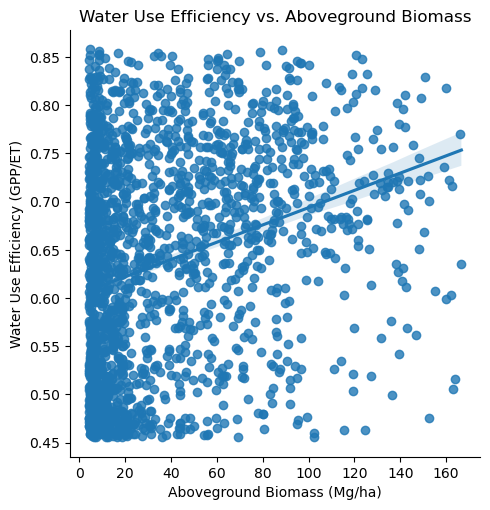

In [11]:
# Plotting the variables and the linear regression

sns.lmplot(x='agbd', y='WUE', data=WUE_agbd_no_outliers, fit_reg=True)
ax = plt.gca()
ax.set(title="Water Use Efficiency vs. Aboveground Biomass",
       xlabel="Aboveground Biomass (Mg/ha)",
       ylabel="Water Use Efficiency (GPP/ET)")

plt.show()